In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
import keras
 #data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airlines-dataset-to-predict-a-delay/Airlines.csv


In [3]:
df=pd.read_csv("../input/airlines-dataset-to-predict-a-delay/Airlines.csv")
df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


We have to predict flight delay on this particualr dataset and we have large data consist of 539383 rows and 9 features.

In [4]:
df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [5]:
df.dtypes

id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

In [6]:
df.describe()

,id,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,269692.000000,2427.928630,3.929668,802.728963,132.202007,0.445442
std,155706.604461,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,712.000000,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,539383.000000,7814.000000,7.000000,1439.000000,655.000000,1.000000


Exploratory Data Analysis

<AxesSubplot:xlabel='Delay', ylabel='count'>

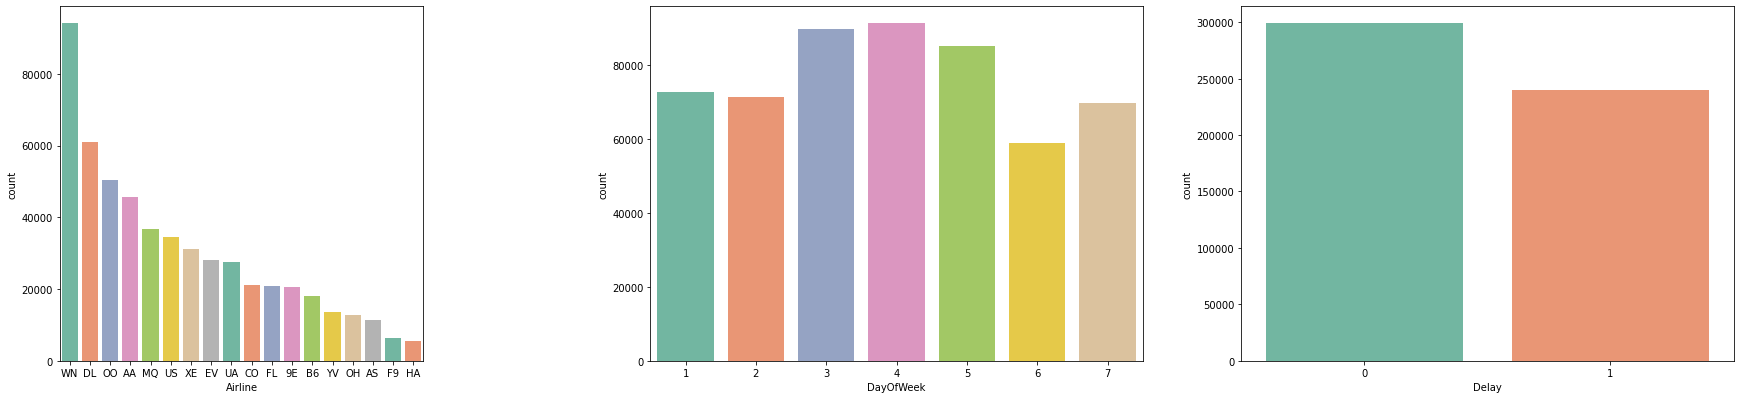

In [7]:
plt.figure(figsize=(30,30))
plt.subplot(4,4,1)
sns.countplot(x = 'Airline', palette='Set2', data = df, order = df['Airline'].value_counts().index)

plt.subplot(4,3,2)
sns.countplot(x = 'DayOfWeek', palette='Set2', data = df)

plt.subplot(4,3,3)
sns.countplot(x = 'Delay', palette='Set2', data = df)

<AxesSubplot:>

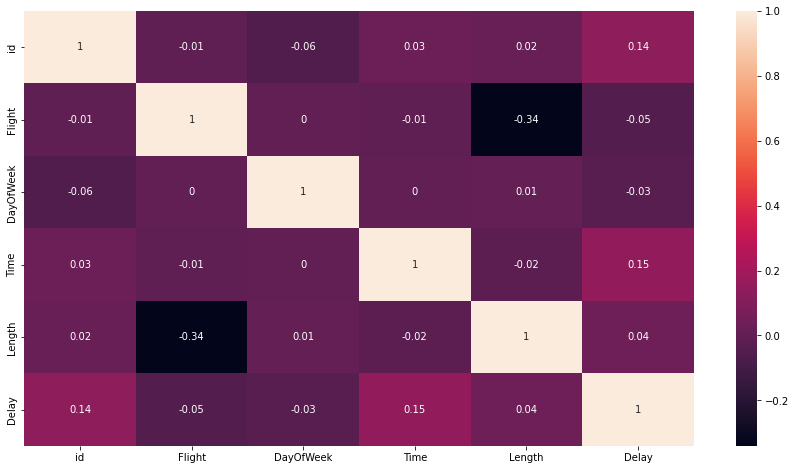

In [8]:
corr=df.corr().round(2)
plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True)

In [9]:
import plotly.graph_objects as go
import plotly.express as px
df_Airportfrom=df[['AirportFrom','id']].groupby('AirportFrom').agg('count').reset_index()
df_Airportfrom=df_Airportfrom.sort_values('id',ascending=True)
fig=px.bar(df_Airportfrom.head(20),x='AirportFrom',y='id')
fig.show()

In [10]:
df_Airportto=df[['AirportTo','id']].groupby('AirportTo').agg('count').reset_index()
df_Airportto=df_Airportto.sort_values('id',ascending=True)
fig=px.bar(df_Airportto.head(20),x='AirportTo',y='id')
fig.show()

In [11]:
df['Airline'].value_counts()

WN    94097
DL    60940
OO    50254
AA    45656
MQ    36605
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: Airline, dtype: int64

In [12]:
len(df['Airline'].unique())

18

In [13]:
len(df['AirportTo'].unique())

293

In [14]:
len(df['AirportFrom'].unique())

293

In [15]:
len(df['DayOfWeek'].unique())

7

In [16]:
len(df['Time'].unique())

1131

In [17]:
df['Delay'].value_counts()

0    299119
1    240264
Name: Delay, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Length'>

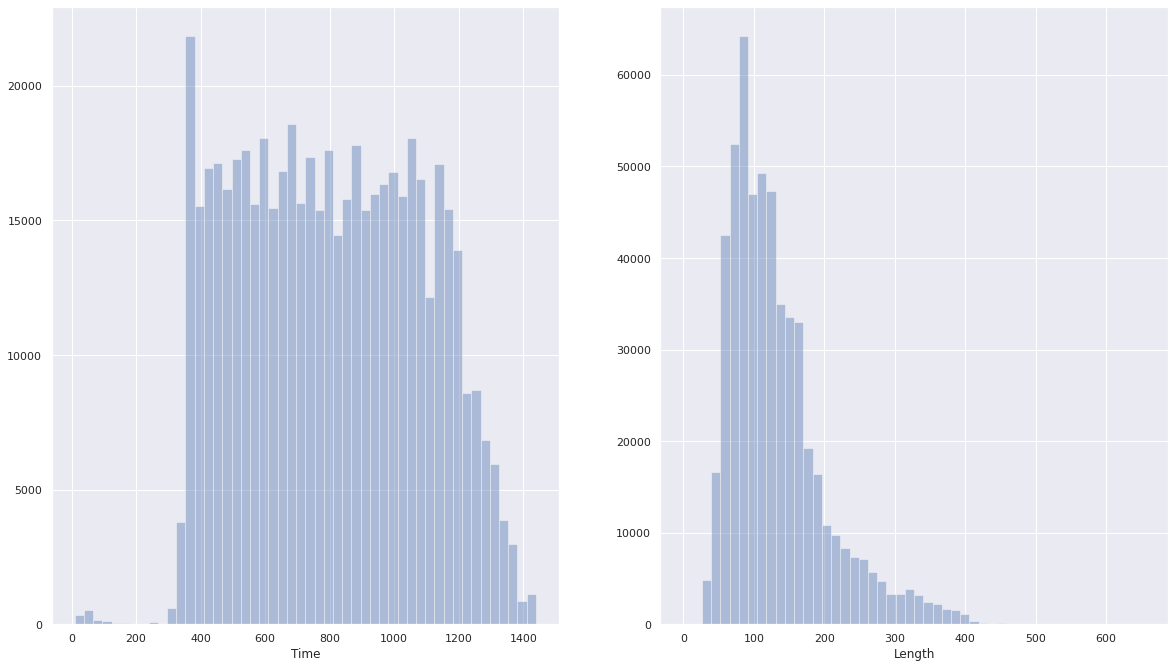

In [18]:
plt.figure(figsize = (20,25))

sns.set(color_codes = True)

plt.subplot(2,2,1)
sns.distplot(df.Time, kde = False)

plt.subplot(2,2,2)
sns.distplot(df.Length, kde = False)

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

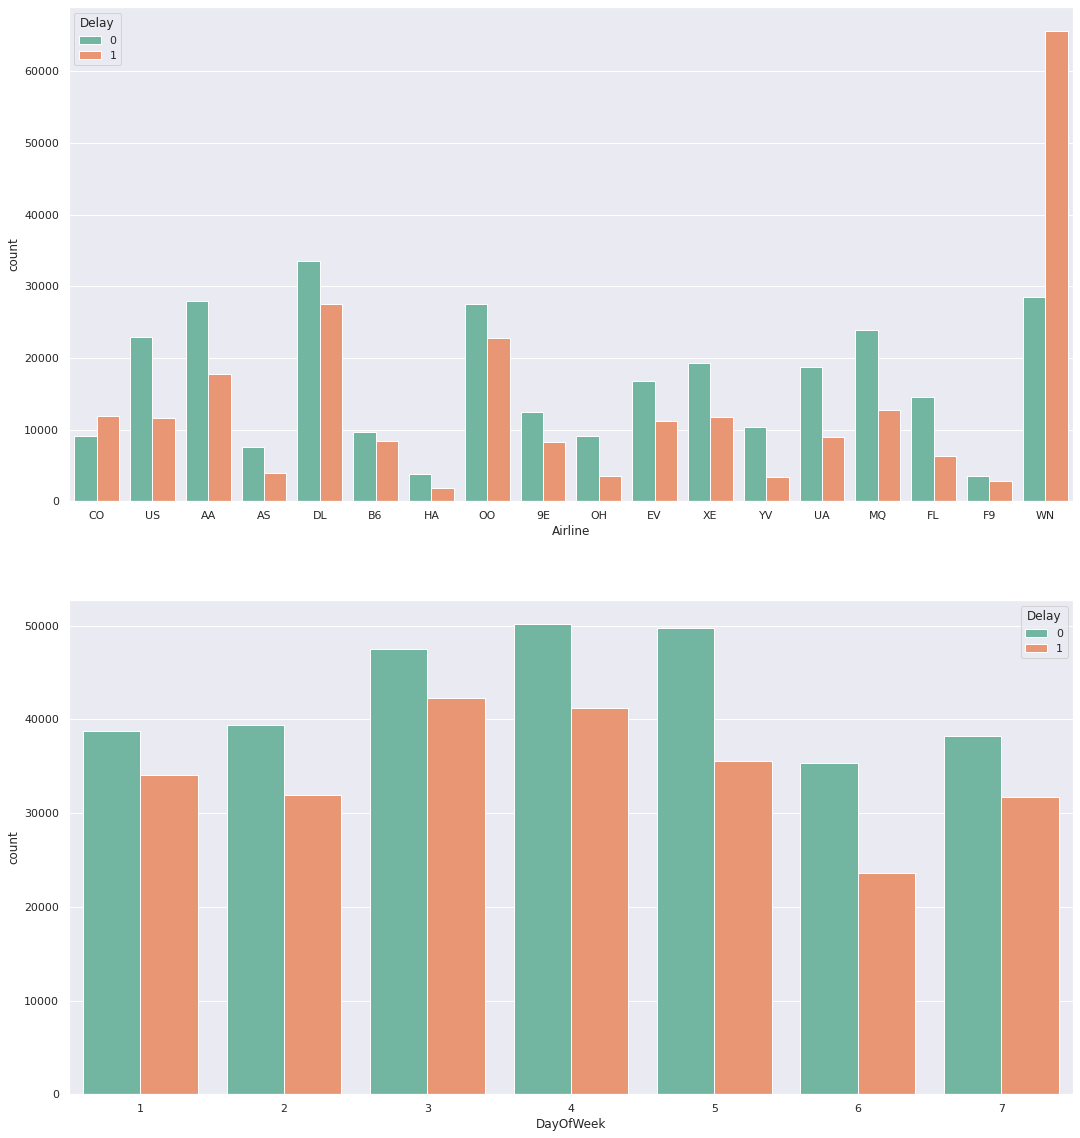

In [19]:
plt.figure(figsize = (18,20))

plt.subplot(2,1,1)
sns.countplot(x = 'Airline', hue= 'Delay', palette='Set2', data = df)

plt.subplot(2,1,2)
sns.countplot(x = 'DayOfWeek', hue= 'Delay', palette='Set2', data = df)

When we compare our variable target with others categorical variables, we can see some insights:
When we see our Variable Airline, we can see that we have some Airlines that has more delay than anothers, like WN, if you catch a fly from WN, probably your flight will be delayed, an interesting point is when we see the variable "DayOfWeek", we can see that we don't have much difference between the days, when we see the continuous variables we don't have a pattern.

In [20]:
df_delay = df[df['Delay'] == 1]
dt_AirportFrom = df_delay[['AirportFrom','Delay']].groupby('AirportFrom').agg('count').reset_index()
dt_AirportFrom = dt_AirportFrom.sort_values('Delay', ascending=False)
fig = px.bar(dt_AirportFrom.head(20), x='AirportFrom', y='Delay')
fig.show()


In [21]:
df_dont_delay = df[df['Delay'] == 0]
dt_AirportFrom = df_dont_delay[['AirportFrom','Delay']].groupby('AirportFrom').agg('count').reset_index()
dt_AirportFrom = dt_AirportFrom.sort_values('Delay', ascending=False)
fig = px.bar(dt_AirportFrom.head(20), x='AirportFrom', y='Delay')
fig.show()


In [22]:
dt_AirportTo = df_delay[['AirportTo','Delay']].groupby('AirportTo').agg('count').reset_index()
dt_AirportTo = dt_AirportTo.sort_values('Delay', ascending=False)
fig = px.bar(dt_AirportTo.head(20), x='AirportTo', y='Delay')
fig.show()

In [23]:
dt_AirportTo = df_dont_delay[['AirportTo','Delay']].groupby('AirportTo').agg('count').reset_index()
dt_AirportTo = dt_AirportTo.sort_values('Delay', ascending=False)
fig = px.bar(dt_AirportTo.head(20), x='AirportTo', y='Delay')
fig.show()

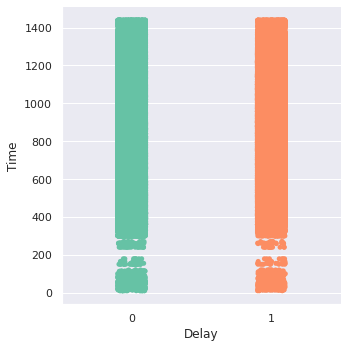

In [24]:
sns.catplot(x = "Delay", y = "Time", palette = "Set2", data = df)

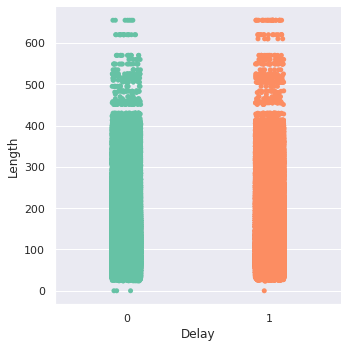

In [25]:
sns.catplot(x = "Delay", y = "Length", palette = "Set2", data = df)

Model Building

In [27]:

df=df.drop('id',1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [28]:
df

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...
539378,CO,178,OGG,SNA,5,1439,326,0
539379,FL,398,SEA,ATL,5,1439,305,0
539380,FL,609,SFO,MKE,5,1439,255,0
539381,UA,78,HNL,SFO,5,1439,313,1


Separating data into dependent and independent variables

In [32]:
X=df.iloc[:,0:7].values
y=df.iloc[:,7].values

In [33]:
from sklearn.preprocessing import LabelEncoder
label_encoder_airline = LabelEncoder()
label_encoder_airportfrom = LabelEncoder()
label_encoder_airportto = LabelEncoder()
X[:,0] = label_encoder_airline.fit_transform(X[:,0])
X[:,2] = label_encoder_airportfrom.fit_transform(X[:,2])
X[:,3] = label_encoder_airportto.fit_transform(X[:,3])

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
X_standard[0]

array([-1.00530759, -1.04425823,  1.37168161, -0.11522128, -0.48555175,
       -2.83309217,  1.03823673])

In [36]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(X)

In [38]:
X_normalization = norm.transform(X)
X_normalization

array([[0.23529412, 0.0343018 , 0.86643836, ..., 0.33333333, 0.00349895,
        0.3129771 ],
       [0.82352941, 0.19928325, 0.74315068, ..., 0.33333333, 0.00349895,
        0.3389313 ],
       [0.05882353, 0.30705235, 0.52739726, ..., 0.33333333, 0.0069979 ,
        0.2519084 ],
       ...,
       [0.47058824, 0.07781902, 0.86643836, ..., 0.66666667, 1.        ,
        0.38931298],
       [0.76470588, 0.00985537, 0.43835616, ..., 0.66666667, 1.        ,
        0.4778626 ],
       [0.82352941, 0.1844362 , 0.52739726, ..., 0.66666667, 1.        ,
        0.45954198]])

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalization, y, test_size = 0.3, random_state = 0)
X_train.shape, y_train.shape

((377568, 7), (377568,))

In [45]:
X_test.shape, y_test.shape

((161815, 7), (161815,))

In [46]:
decision_entropy = DecisionTreeClassifier(criterion = 'entropy', max_depth= 3, random_state=0)

In [47]:
decision_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [48]:
pred=decision_entropy.predict(X_test)

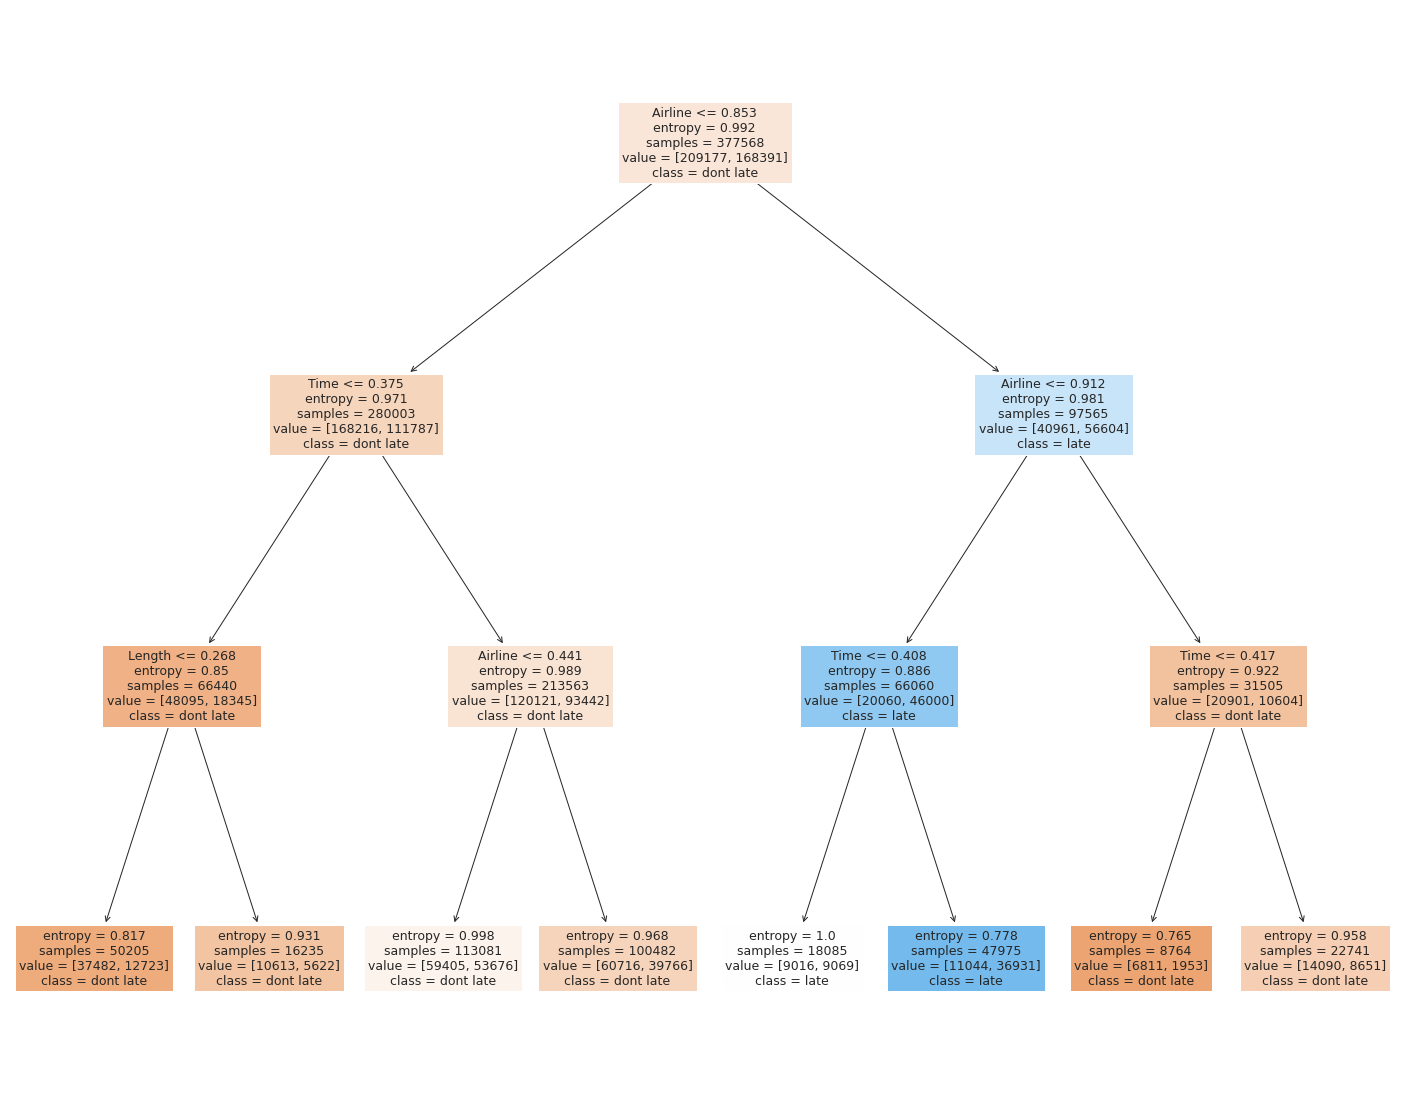

In [50]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(decision_entropy, feature_names=df.columns[:-1], class_names=['dont late', 'late'], filled=True);

0.6255229737663381

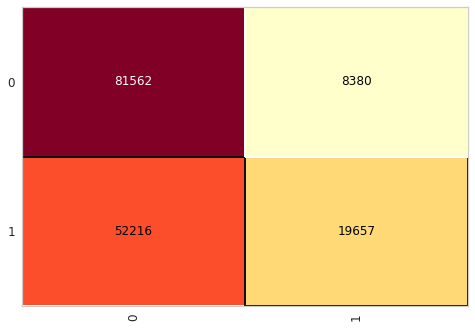

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
cm =ConfusionMatrix(decision_entropy)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [58]:
classification_decision_entropy = (classification_report(y_test, pred))
print(classification_decision_entropy)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     89942
           1       0.70      0.27      0.39     71873

    accuracy                           0.63    161815
   macro avg       0.66      0.59      0.56    161815
weighted avg       0.65      0.63      0.58    161815



In [59]:
columns = df.iloc[:, 0:7].columns
feature_imp = pd.Series(decision_entropy.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

Airline        0.664998
Time           0.319672
Length         0.015330
Flight         0.000000
AirportFrom    0.000000
AirportTo      0.000000
DayOfWeek      0.000000
dtype: float64

Seeing the most important variable using this model, we can see that it uses the variables "Airline" and "Time" to make a decision about the Flight be late or no.

In [60]:
decision_gini = DecisionTreeClassifier(max_depth= 3, random_state=0)
decision_gini.fit(X_train, y_train)
DecisionTreeClassifier(max_depth=3, random_state=0)
previsoes = decision_gini.predict(X_test)

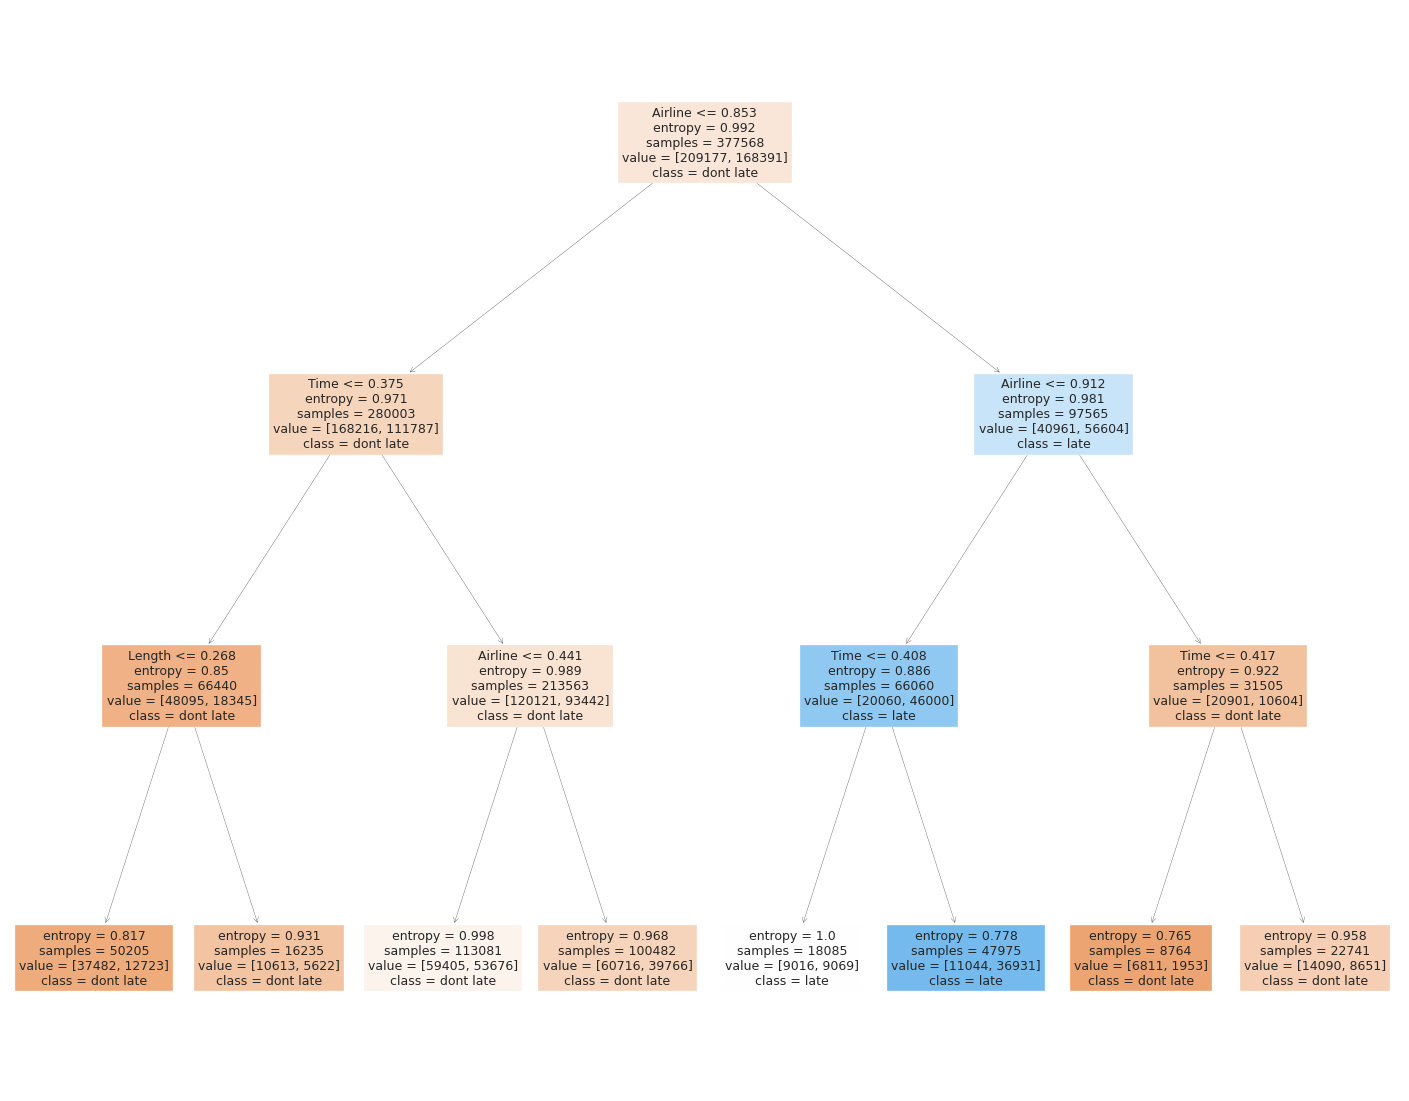

In [61]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(decision_entropy, feature_names=df.columns[:-1], class_names=['dont late', 'late'], filled=True);

0.6262089423106634

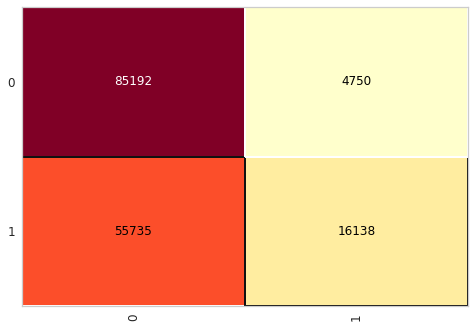

In [62]:
cm = ConfusionMatrix(decision_gini)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [63]:
classification_decision_gini = (classification_report(y_test, pred))
print(classification_decision_gini)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73     89942
           1       0.70      0.27      0.39     71873

    accuracy                           0.63    161815
   macro avg       0.66      0.59      0.56    161815
weighted avg       0.65      0.63      0.58    161815



In [64]:
feature_imp = pd.Series(decision_gini.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

Airline        0.683418
Time           0.303341
Length         0.013241
Flight         0.000000
AirportFrom    0.000000
AirportTo      0.000000
DayOfWeek      0.000000
dtype: float64

In [65]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100, max_depth= 3, criterion = 'entropy', random_state = 0)
random_forest.fit(X_train, y_train)
RandomForestClassifier(criterion='entropy', max_depth=3, random_state=0)
previsoes = random_forest.predict(X_test)

0.6278033556839601

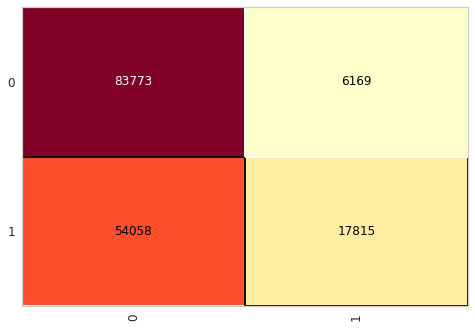

In [66]:
cm = ConfusionMatrix(random_forest)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [67]:
classification_random_entropy = (classification_report(y_test, previsoes))
print(classification_random_entropy)

              precision    recall  f1-score   support

           0       0.61      0.93      0.74     89942
           1       0.74      0.25      0.37     71873

    accuracy                           0.63    161815
   macro avg       0.68      0.59      0.55    161815
weighted avg       0.67      0.63      0.57    161815



In [68]:
feature_imp = pd.Series(random_forest.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

Airline        0.412551
Time           0.357931
Flight         0.086245
AirportTo      0.070035
Length         0.050024
AirportFrom    0.013180
DayOfWeek      0.010034
dtype: float64

In [69]:
random_forest = RandomForestClassifier(n_estimators = 100, max_depth= 3, random_state = 0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

0.6275129005345611

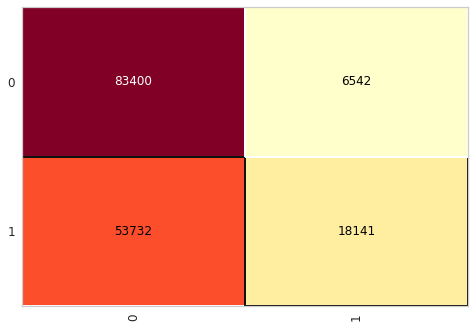

In [72]:
previsoes = random_forest.predict(X_test)

cm = ConfusionMatrix(random_forest)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [74]:
classification_random_gini = (classification_report(y_test, previsoes))
print(classification_random_gini)

              precision    recall  f1-score   support

           0       0.61      0.93      0.73     89942
           1       0.73      0.25      0.38     71873

    accuracy                           0.63    161815
   macro avg       0.67      0.59      0.56    161815
weighted avg       0.66      0.63      0.58    161815



In [76]:
feature_imp = pd.Series(random_forest.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

Airline        0.426550
Time           0.345926
Flight         0.086587
AirportTo      0.069137
Length         0.049145
AirportFrom    0.011465
DayOfWeek      0.011191
dtype: float64

In [77]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(metric = 'minkowski', p = 2)

In [79]:
k_list = list(range(1,31))
k_values = dict(n_neighbors = k_list)
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(knn, k_values, cv = 5, scoring = 'accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [80]:
grid.best_params_, grid.best_score_

({'n_neighbors': 30}, 0.6339520335775242)

In [81]:
knn = KNeighborsClassifier(n_neighbors = 8, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [82]:
previsoes = knn.predict(X_test)

0.6259926459228131

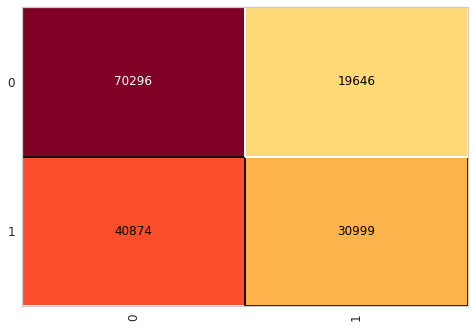

In [85]:
cm = ConfusionMatrix(knn)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

In [86]:
classification_knn = (classification_report(y_test, previsoes))
print(classification_knn)

              precision    recall  f1-score   support

           0       0.63      0.78      0.70     89942
           1       0.61      0.43      0.51     71873

    accuracy                           0.63    161815
   macro avg       0.62      0.61      0.60    161815
weighted avg       0.62      0.63      0.61    161815



Experimented with Three models(KNN,Decision Tree,Random Forest)but none of the them giving good accuracy.This dataset is not appropriate and its challenging to get good accuracy so we can improvise our data or add some more features that can explain the reason for delaying flight and built up a story for that.

In this project we can see that we have numerical variables and some categorical variales, in our Data Visualization we can see that we have some Airlines that has more Delays than Anothers, the same thing when we See the Airports, its interesting that we have almost the same values in Delays and Not Delays.

When we look at machine learning models, we can't get a good models to preview when we have delay when we use our Original Data, even when we Scaling the data, then i decided to create new variables using your original data, transforming some values in groups, like Airline, Airport From and Airport To.

But even so we ended up not being able to create a good model to predict when the plane will have a delay with this data that we have available, to predict if the plane will not have a delay we got some good models.

Other interesting thing to see is the most important variables in the Decision Tree and Random ForestModel, We can see that the most important variable of model is Airline and our Second Variable is "Time", which shows us that these are the variables that most explain when the Flight will be Delayed or Not.

Maybe if we have more informations about the flights like such as weather forecast, time of year, or things that influence the use of planes, we could get better results.